In [1]:
import sys
sys.path.append('/global/homes/j/jpiat/hodpy/')

import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from hodpy.cosmology import CosmologyAbacus
from pycorr import TwoPointCorrelationFunction,utils
from hodpy.k_correction import GAMA_KCorrection
from hodpy import lookup

cosmo = CosmologyAbacus(0)  #c000 cosmology
kcorr = GAMA_KCorrection(cosmo, k_corr_file=lookup.kcorr_file, cubic_interpolation=True)

In [ ]:
box_file = '/pscratch/sd/a/amjsmith/AbacusSummit/secondgen_new/z0.200/AbacusSummit_base_c000_ph000/BGS_box_S.fits'
box_file_jp = '/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph000/cubic_box/BGS_box_S.fits'

box_cat = fits.open(box_file)
box = Table(box_cat[1].data)
box_cat.close()

box_cat = fits.open(box_file_jp)
box_jp = Table(box_cat[1].data)
box_cat.close()

In [ ]:
z = 0.2
a = 1/(1+z)
H = cosmo.H(z)
h = cosmo.H(0)/100

box['x_rsd'] = box['x'] + box['vx']/(a*H/h)
pos = box['x_rsd','y','z']

box_jp['x_rsd'] = box_jp['x'] + box_jp['vx']/(a*H/h)
pos_jp = box_jp['x_rsd','y','z']

In [ ]:
M = box['R_MAG_ABS']
M_jp = box_jp['R_MAG_ABS']


print(np.min(M))
M_bins = np.arange(-22,-17.5,0.5)

## Test with BGS data

In [ ]:
wp_y1 = np.loadtxt('wp_target_y1_pip_ang_wsys_pi80.dat')
wp_y1[:,0]


for i in range(len(M_bins)):

    inside = M<=M_bins[i]
    
    posM = pos[inside]
    pos_arr = np.array([posM['x_rsd'],posM['y'],posM['z']])
    
    edges = (np.logspace(-2, 2, 51), np.linspace(-80, 80, 161))
    result = TwoPointCorrelationFunction('rppi', edges, boxsize=2000, position_type = 'xyz', los='x', data_positions1=pos_arr, engine='corrfunc', nthreads=4)
    sep, wp = result(pimax=None, return_sep=True)

    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_title(f'M < {M_bins[i]}')
    ax.plot(sep, sep * wp)
    ax.plot(wp_y1[:,0], wp_y1[:,0] * wp_y1[:,i+1],'r--')
    ax.set_xlabel(r'$r_{p}$')
    ax.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
    ax.grid(True)

## Test with best-fitting HOD

In [ ]:
wp_hod = np.loadtxt('diff_start_low_prior_1_CF_wsys.txt')
wp_hod[:,0]


for i,threshold in enumerate(M_bins):

    inside = M<=threshold
    
    posM = pos[inside]
    pos_arr = np.array([posM['x_rsd'],posM['y'],posM['z']])

    edges = (np.logspace(-2, 2, 25), np.linspace(-80, 80, 161))
    result = TwoPointCorrelationFunction('rppi', edges, boxsize=2000, position_type = 'xyz', los='x', data_positions1=pos_arr, engine='corrfunc', nthreads=4)
    sep, wp = result(pimax=None, return_sep=True)

    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_title(f'M < {threshold}')
    ax.plot(sep, sep * wp)
    ax.plot(wp_hod[:,0], wp_hod[:,0] * wp_hod[:,i+1],'r--')
    ax.set_xlabel(r'$r_{p}$')
    ax.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
    ax.grid(True)
    plt.show()


## Test with best-fitting HOD for 2 ph000 mocks

In [ ]:
wp_hod = np.loadtxt('diff_start_low_prior_1_CF_wsys.txt')

ax = plt.gca()
ax.set_xscale('log')
ax.set_title(f'M < -20')
ax.set_xlabel(r'$r_{p}$')
ax.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
ax.grid(True)
ax.plot(wp_hod[:,0], wp_hod[:,0] * wp_hod[:,5],'r--',label='best-fitting HOD')


posM = pos[M<=-20]
pos_arr = np.array([posM['x_rsd'],posM['y'],posM['z']])

posM_jp = pos_jp[M_jp<=-20]
pos_arr_jp = np.array([posM_jp['x_rsd'],posM_jp['y'],posM_jp['z']])

edges = (np.logspace(-2, 2, 25), np.linspace(-80, 80, 161))
result = TwoPointCorrelationFunction('rppi', edges, boxsize=2000, position_type = 'xyz', los='x', data_positions1=pos_arr, engine='corrfunc', nthreads=4)
sep, wp = result(pimax=None, return_sep=True)

print("Projected correlation function for Alex's mock")

ax.plot(sep, sep * wp,label="Alex's mock")

result1 = TwoPointCorrelationFunction('rppi', edges, boxsize=2000, position_type = 'xyz', los='x', data_positions1=pos_arr_jp, engine='corrfunc', nthreads=4)
sep1, wp1 = result1(pimax=None, return_sep=True)

ax.plot(sep1, sep1 * wp1, ls='-.', label="Jade's mock")

plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.grid()
plt.xscale('log')
plt.scatter(sep,wp/wp1)
plt.ylabel(r'w$_p^{\rm Alex}$ / w$_p^{\rm Jade}$')
plt.xlabel(r'$r_{p}$')
plt.show()

## Test with best-fitting HOD for ph000 and ph006 mocks

In [ ]:
wp_hod = np.loadtxt('diff_start_low_prior_1_CF_wsys.txt')
box_file2 = '/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph006/cubic_box/BGS_box_S.fits'

box_cat2 = fits.open(box_file2)
box2 = Table(box_cat[1].data)
box_cat2.close()

z = 0.2
a = 1/(1+z)
H = cosmo.H(z)
h = cosmo.H(0)/100

box2['x_rsd'] = box2['x'] + box2['vx']/(a*H/h)
pos2 = box2['x_rsd','y','z']

M2 = box2['R_MAG_ABS']

posM1 = pos_jp[M_jp<=-20]
pos_arr1 = np.array([posM1['x_rsd'],posM1['y'],posM1['z']])

posM2 = pos2[M2<=-20]
pos_arr2 = np.array([posM2['x_rsd'],posM2['y'],posM2['z']])

edges = (np.logspace(-2, 2, 25), np.linspace(-80, 80, 161))
result1 = TwoPointCorrelationFunction('rppi', edges, boxsize=2000, position_type = 'xyz', los='x', data_positions1=pos_arr1, engine='corrfunc', nthreads=4)
sep1, wp1 = result1(pimax=None, return_sep=True)

edges = (np.logspace(-2, 2, 25), np.linspace(-80, 80, 161))
result2 = TwoPointCorrelationFunction('rppi', edges, boxsize=2000, position_type = 'xyz', los='x', data_positions1=pos_arr2, engine='corrfunc', nthreads=4)
sep2, wp2 = result2(pimax=None, return_sep=True)

In [ ]:
ax = plt.gca()
ax.set_xscale('log')
ax.set_title(f'M < -20')
ax.set_xlabel(r'$r_{p}$')
ax.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
ax.grid(True)
ax.plot(wp_hod[:,0], wp_hod[:,0] * wp_hod[:,5],'r--',label='best-fitting HOD')
ax.plot(sep1, sep1 * wp1, ls='-', label="ph000")
ax.plot(sep2, sep2 * wp2, ls='-.', label="ph006")
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.grid()
plt.xscale('log')
plt.scatter(sep1,wp1/wp2)
plt.ylabel(r'w$_p^{\rm po000}$ / w$_p^{\rm ph006}$')
plt.xlabel(r'$r_{p}$')
plt.show()

## Test with best-fitting HOD and corrected mock

In [ ]:
box_file = '/pscratch/sd/a/amjsmith/AbacusSummit/secondgen_new/z0.200/AbacusSummit_base_c000_ph000/box_conc/BGS_box_new_S.fits'

box_cat = fits.open(box_file)
box = Table(box_cat[1].data)
box_cat.close()

z = 0.2
a = 1/(1+z)
H = cosmo.H(z)
h = cosmo.H(0)/100

box['x_rsd'] = box['x'] + box['vx']/(a*H/h)
pos = box['x_rsd','y','z']

M = box['R_MAG_ABS']

posM = pos[M<=-20]
pos_arr = np.array([posM['x_rsd'],posM['y'],posM['z']])

edges = (np.logspace(-2, 2, 25), np.linspace(-80, 80, 161))
result = TwoPointCorrelationFunction('rppi', edges, boxsize=2000, position_type = 'xyz', los='x', data_positions1=pos_arr, engine='corrfunc', nthreads=4)
sep, wp = result(pimax=None, return_sep=True)

In [ ]:
wp_hod = np.loadtxt('diff_start_low_prior_1_CF_wsys.txt')
wp_hod_nosys = np.loadtxt('diff_start_low_prior_1_CF_nowsys.txt')

rp_bins = np.logspace(-2, 2, 25)
rp = 0.5*(rp_bins[1:]+rp_bins[:-1])

ax = plt.gca()
ax.set_xscale('log')
ax.set_title(f'M < -20')
ax.set_xlabel(r'$r_{p}$')
ax.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
ax.grid(True)
ax.plot(wp_hod[:,0], wp_hod[:,0] * wp_hod[:,5],'r--',label='best-fitting HOD wsys')
ax.plot(wp_hod_nosys[:,0], wp_hod_nosys[:,0] * wp_hod_nosys[:,5],'g--',label='best-fitting HOD nowsys')
ax.plot(rp, rp * wp, ls='-', label="ph000")
plt.legend()
plt.show()

## Comparison test for wsys and nowsys

In [ ]:
#file_wsys = '/pscratch/sd/a/amjsmith/AbacusSummit/secondgen_new/z0.200/AbacusSummit_base_c000_ph000/box_conc/BGS_box_new_S.fits'
file_wsys = '/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph000/cubic_box/wsys/BGS_box_S.fits'
file_nowsys = '/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph000/cubic_box/nowsys/BGS_box_S.fits'

cat_wsys = fits.open(file_wsys)
box_wsys = Table(cat_wsys[1].data)
cat_wsys.close()

cat_nowsys = fits.open(file_nowsys)
box_nowsys = Table(cat_nowsys[1].data)
cat_nowsys.close()

M_wsys = box_wsys['R_MAG_ABS']
M_nowsys = box_nowsys['R_MAG_ABS']

threshold = -21.5

z = 0.2
a = 1/(1+z)
H = cosmo.H(z)
h = cosmo.H(0)/100

box_wsys['x_rsd'] = box_wsys['x'] + box_wsys['vx']/(a*H/h)
pos_wsys = box_wsys['x_rsd','y','z'][M_wsys<=threshold]

box_nowsys['x_rsd'] = box_nowsys['x'] + box_nowsys['vx']/(a*H/h)
pos_nowsys = box_nowsys['x_rsd','y','z'][M_nowsys<=threshold]

pos_wsys_arr = np.array([pos_wsys['x_rsd'],pos_wsys['y'],pos_wsys['z']])
pos_nowsys_arr = np.array([pos_nowsys['x_rsd'],pos_nowsys['y'],pos_nowsys['z']])

edges = (np.logspace(-2, 2, 25), np.linspace(-80, 80, 161))

result = TwoPointCorrelationFunction('rppi', edges, boxsize=2000, position_type = 'xyz', los='x', data_positions1=pos_wsys_arr, engine='corrfunc', nthreads=8)
sep, wp_wsys = result(pimax=None, return_sep=True)

print('wsys finished')

result = TwoPointCorrelationFunction('rppi', edges, boxsize=2000, position_type = 'xyz', los='x', data_positions1=pos_nowsys_arr, engine='corrfunc', nthreads=4)
sep, wp_nowsys = result(pimax=None, return_sep=True)

print('nowsys finished')

In [ ]:
wp_hod = np.loadtxt('best_fitting_HODs/diff_start_low_prior_1_CF_wsys.txt')        
wp_hod_nowsys = np.loadtxt('best_fitting_HODs/diff_start_low_prior_1_CF_nowsys.txt')

rp_bins = np.logspace(-2, 2, 25)
rp = 0.5*(rp_bins[1:]+rp_bins[:-1])

ax = plt.gca()
ax.set_xscale('log')
ax.set_title(f'M < {threshold}')
ax.set_xlabel(r'$r_{p}$')
ax.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
ax.grid(True)
ax.plot(rp, rp * wp_wsys, ls='-', label="ph000 // wsys")
ax.plot(rp, rp * wp_nowsys, ls='-', c='g', label="ph000 // nowsys")
ax.plot(wp_hod[:,0], rp * wp_hod[:,2],'r--',label='best-fitting HOD wsys')
ax.plot(wp_hod[:,0], rp * wp_hod_nowsys[:,2],'--',color='orange',label='best-fitting HOD nowsys')

plt.legend()
plt.show()

## Test Individual files

In [ ]:
def proj_corr_func_ind(box_num):

    file = f'/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph000/cubic_box/wsys/BGS_box_S_{box_num:03d}.fits'
    
    cat = fits.open(file)
    box = Table(cat[1].data)
    cat.close()
    
    L = 2000/34
    mask = (box['x']>-1000+L*box_num)*(box['x']<-1000+L*(box_num+1))
    box = box[mask]
    
    rand = np.array([np.random.uniform(-1000+L*box_num,-1000+L*(box_num+1),len(box)),
                    np.random.uniform(-1000,1000,len(box)),
                    np.random.uniform(-1000,1000,len(box))])
    
    M = box['R_MAG_ABS']
    
    z = 0.2
    a = 1/(1+z)
    H = cosmo.H(z)
    h = cosmo.H(0)/100
    
    box['z_rsd'] = box['z'] + box['vz']/(a*H/h)
    pos = box['x','y','z_rsd'][M<=-20]
    
    pos_arr = np.array([pos['x'],pos['y'],pos['z_rsd']])
    
    edges = (np.logspace(-2, 2, 25), np.linspace(-80, 80, 161))
    
    result = TwoPointCorrelationFunction('rppi', edges, position_type = 'xyz', los='z', data_positions1=pos_arr, randoms_positions1=rand, engine='corrfunc', nthreads=8)
    sep, wp = result(pimax=None, return_sep=True)
    
    np.savetxt(f'/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph000/cubic_box/wsys/wp/wp_S_{box_num:03d}.dat',wp)
    
    print(f'box {box_num:1d} done')

In [ ]:
for box in range(34):
    
    proj_corr_func_ind(box)

In [ ]:
wp_hod = np.loadtxt('/best_fitting_HODs/diff_start_low_prior_1_CF_wsys.txt')        # files were exchanged
wp_hod_nowsys = np.loadtxt('/best_fitting_HODs/diff_start_low_prior_1_CF_nowsys.txt')

rp_bins = np.logspace(-2, 2, 25)
rp = 0.5*(rp_bins[1:]+rp_bins[:-1])

ax = plt.gca()
ax.set_xscale('log')
ax.set_title(f'M < -20')
ax.set_xlabel(r'$r_{p}$')
ax.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
ax.grid(True)


for box in range(34):

    wp = np.loadtxt(f'/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph000/cubic_box/wsys/wp/wp_S_{box:03d}.dat')
    ax.plot(rp, rp * wp, c='c', ls='-', alpha=0.4)

ax.plot(wp_hod[:,0], wp_hod[:,0] * wp_hod[:,5],'r--',label='best-fitting HOD wsys')
plt.legend()
plt.show()

## Test Lightcones

In [6]:
file = '/pscratch/sd/a/amjsmith/AbacusSummit/secondgen_new/lightcone/AbacusSummit_base_c000_ph000/BGS_lightcone_S.fits'

cat = fits.open(file)
lc = Table(cat[1].data)
cat.close()

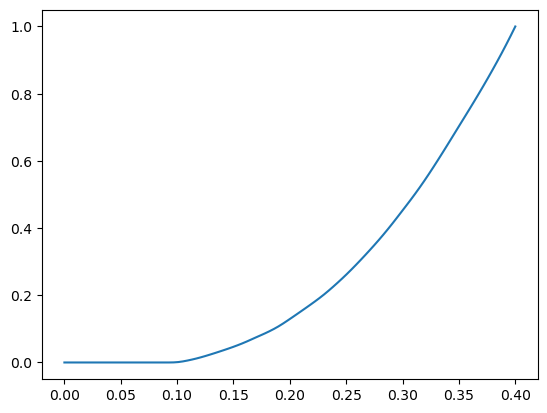

In [7]:
zmax = 0.4  #np.max(data['zobs'])
M = lc['abs_mag']
threshold = -21.5

mask = (M<=threshold)*(lc['ra']<=90)*(lc['zobs']<=zmax)
data = lc[mask]
pos_data = np.array([data['ra'],data['dec'],cosmo.comoving_distance(data['zobs'])])

RA_rand = np.random.uniform(0,90,len(data)*10)
DEC_rand = np.degrees(np.arcsin(np.random.uniform(0,1,len(data)*10)))
z_rand = random_dist(data['zobs'],0,zmax,0.01,len(data)*10)
pos_rand = np.array([RA_rand,DEC_rand,cosmo.comoving_distance(z_rand)])

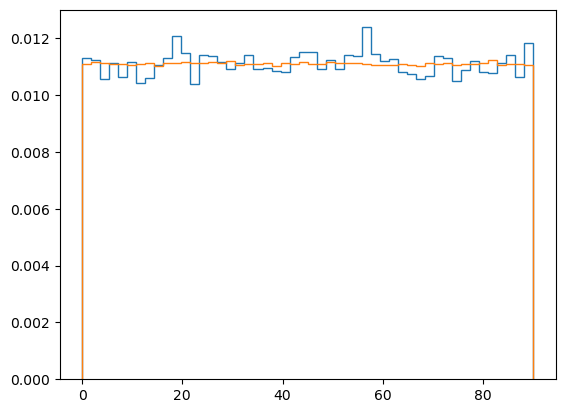

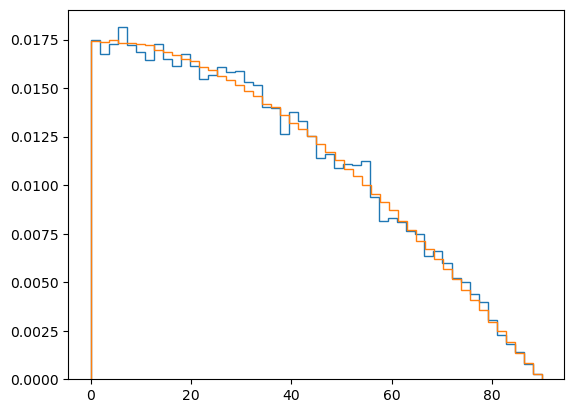

In [8]:
plt.figure()
plt.hist(data['ra'],50,density=True,histtype='step')
plt.hist(RA_rand,50,density=True,histtype='step')

plt.figure()
plt.hist(data['dec'],50,density=True,histtype='step')
plt.hist(DEC_rand,50,density=True,histtype='step');

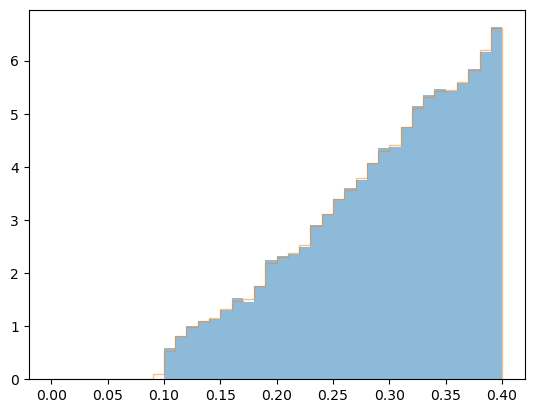

In [9]:
b = np.arange(0,zmax+0.01,0.01)

plt.hist(data['zobs'],bins=b,alpha=0.5,density=True)
plt.hist(z_rand,bins=b,alpha=0.5,density=True,histtype='step');

In [ ]:
from pycorr import KMeansSubsampler
subsampler = KMeansSubsampler(mode='angular', positions=pos_data, nsamples=128, nside=512, random_state=42, position_type='rdd')
labels = subsampler.label(pos_data)
subsampler.log_info('Labels from {:d} to {:d}.'.format(labels.min(), labels.max()))

fig = plt.figure(figsize=(4, 4))
ax = plt.gca()
ax.scatter(*pos_data[:2], marker='.', c=labels)
ax.set_xlabel(r'R.A. [$\mathrm{deg}$]')
ax.set_ylabel(r'Dec. [$\mathrm{deg}$]')
plt.show()

In [10]:
#data_samples = subsampler.label(pos_data)
#randoms_samples = subsampler.label(pos_rand)
edges = (np.logspace(-2, 2, 25), np.linspace(-80, 80, 161))
result = TwoPointCorrelationFunction('rppi', edges, data_positions1=pos_data, randoms_positions1=pos_rand, position_type='rdd',
                                     engine='corrfunc', compute_sepsavg=False, nthreads=24)

In [11]:
wp = result.get_corr(mode='wp')

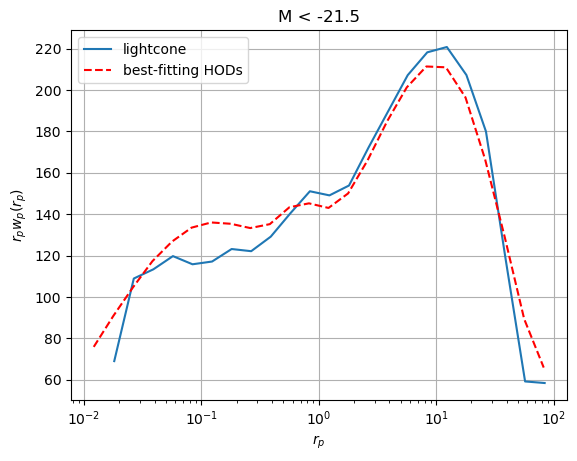

In [12]:
wp_hod = np.loadtxt('best_fitting_HODs/diff_start_low_prior_1_CF_wsys.txt')        

rp_bins = np.logspace(-2, 2, 25)
rp = 0.5*(rp_bins[1:]+rp_bins[:-1])

ax = plt.gca()
ax.set_xscale('log')
ax.set_title(f'M < {threshold}')
ax.set_xlabel(r'$r_{p}$')
ax.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
ax.grid(True)
ax.plot(rp, rp * wp, label="lightcone")
ax.plot(wp_hod[:,0], rp * wp_hod[:,2],'r--',label='best-fitting HODs')

plt.legend()
plt.show()

In [ ]:
mask1 = (sky['R_MAG_APP']<20.2)*(sky['Z']<=zmax)*(sky['Z']>=0.1)
mask2 = (lc['zobs']<=zmax)

h_sky,b_sky = np.histogram(sky['R_MAG_ABS'][mask1],50)
h_lc,_ = np.histogram(lc['abs_mag'][mask2],bins=b_sky)
c_sky = 0.5*(b_sky[1:]+b_sky[:-1])

plt.figure()
plt.title('m < 20.2')
plt.xlabel('M')
plt.plot(c_sky,h_sky,label='cutsky')
plt.plot(c_sky,h_lc*8,label='lightcone (*8)');
plt.legend();

In [ ]:
mask1 = sky['R_MAG_APP']<20.2
mask2 = lc['app_mag']<20.2

h_sky,b_sky = np.histogram(sky['Z_COSMO'][mask1],50)
h_lc,_ = np.histogram(lc['zcos'][mask2],bins=b_sky)
c_sky = 0.5*(b_sky[1:]+b_sky[:-1])

plt.figure()
plt.title('m_app < 20.2')
plt.xlabel('z_cos')
plt.plot(c_sky,h_sky,label='cutsky')
plt.plot(c_sky,h_lc*8,label='lightcone (*8)');
plt.legend();

## Test magnitude correction for previous 2nd gen mocks 

In [ ]:
path_in = '/global/cfs/cdirs/desi/cosmosim/SecondGenMocks/AbacusSummit/CutSky/BGS/v0.1/z0.200/'
file_cutsky = path_in+'cutsky_BGS_z0.200_AbacusSummit_base_c000_ph006.fits'

sky = fits.open(file_cutsky)
data = sky[1].data
sky.close()

z = data['Z']
m = data['R_MAG_APP']
M = data['R_MAG_ABS']
col = data['G_R_REST']

hm, bm = np.histogram(m, 50)
m_eff = 0.5*(bm[1:]+bm[:-1])

D_L = (1.+z) * cosmo.comoving_distance(z)

In [ ]:
E = 0.8 * (z - 0.1)
m_test = M - E + 5*np.log10(D_L) + 25 + kcorr.k(z,col)

hm_test, bm_test = np.histogram(m_test, 50)
m_eff_test = 0.5*(bm_test[1:]+bm_test[:-1])

In [ ]:
plt.figure()
plt.xlabel('m')
plt.ylabel('N(m)')
plt.plot(m_eff, hm, label='R_MAG_APP')
plt.plot(m_eff_test, hm_test, label='Q=0.8')
plt.legend()